In [8]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [17]:
import os, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Paths & hyperparams
data_dir    = r"C:\Users\646ca\furniture-dataset\classes"
save_dir    = "./new_model"
os.makedirs(save_dir, exist_ok=True)

img_size    = 128
batch_size  = 32
learning_rate = 3e-5
num_epochs  = 20
val_pct     = 0.2

# 3) Transforms & dataset
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# load everything with train_tf first; we'll swap for val
full_ds = datasets.ImageFolder(data_dir, transform=train_tf)
num_total = len(full_ds)
num_val   = int(val_pct * num_total)
num_train = num_total - num_val

train_ds, val_ds = random_split(full_ds, [num_train, num_val],
                                generator=torch.Generator().manual_seed(42))
# swap transform on val split
val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)

# save class<->idx mapping
cls_map = full_ds.class_to_idx
with open(os.path.join(save_dir, "class_to_idx.json"), "w") as f:
    json.dump(cls_map, f)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Model, loss, optimizer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(cls_map))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Training loop
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    
    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    val_acc = correct/total
    print(f"Epoch {epoch}/{num_epochs} — train loss: {avg_loss:.4f} — val acc: {val_acc:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 6) Save & reload for inference
state_path = os.path.join(save_dir, "furniture_resnet18.pth")
torch.save(model.state_dict(), state_path)
print("Model saved to", state_path)

Using device: cpu


C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\646ca/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|████████████████████████████████

Epoch 1/20 — train loss: 1.5721 — val acc: 0.5463
Epoch 2/20 — train loss: 0.7696 — val acc: 0.7130
Epoch 3/20 — train loss: 0.4573 — val acc: 0.7593
Epoch 4/20 — train loss: 0.2883 — val acc: 0.7778
Epoch 5/20 — train loss: 0.1979 — val acc: 0.8056
Epoch 6/20 — train loss: 0.1336 — val acc: 0.8333
Epoch 7/20 — train loss: 0.0920 — val acc: 0.8426
Epoch 8/20 — train loss: 0.0719 — val acc: 0.8519
Epoch 9/20 — train loss: 0.0595 — val acc: 0.8611
Epoch 10/20 — train loss: 0.0489 — val acc: 0.8519
Epoch 11/20 — train loss: 0.0374 — val acc: 0.8333
Epoch 12/20 — train loss: 0.0335 — val acc: 0.8611
Epoch 13/20 — train loss: 0.0319 — val acc: 0.8611
Epoch 14/20 — train loss: 0.0207 — val acc: 0.8426
Epoch 15/20 — train loss: 0.0192 — val acc: 0.8426
Epoch 16/20 — train loss: 0.0234 — val acc: 0.8426
Epoch 17/20 — train loss: 0.0226 — val acc: 0.8426
Epoch 18/20 — train loss: 0.0146 — val acc: 0.8426
Epoch 19/20 — train loss: 0.0152 — val acc: 0.8426
Epoch 20/20 — train loss: 0.0160 — val a

C:\Users\646ca\AppData\Local\Temp\ipykernel_17532\2174914825.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model/furniture_resnet1

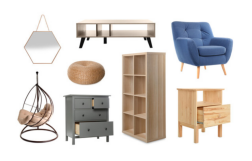

Top predictions:
living room: 0.7981
sectional: 0.0642
chair: 0.0436


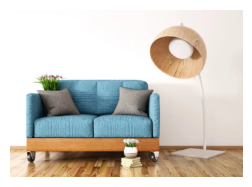

Top predictions:
living room: 0.9567
storage: 0.0175
chair: 0.0117


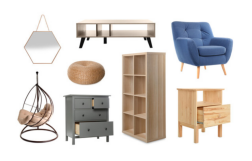

Top predictions:
living room: 0.7981
sectional: 0.0642
chair: 0.0436


In [30]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
from PIL import Image
import requests
from io import BytesIO
import json
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class mapping
with open('./model/class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Create inverse mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Model initialization and loading
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
model.load_state_dict(torch.load("./model/furniture_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

# Image preprocessing for inference
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

def display_image(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def load_image(img_path_or_url):
    """Load image from URL or local path."""
    if img_path_or_url.startswith(('http://', 'https://')):
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(img_path_or_url).convert("RGB")
    return img

def predict(image_path_or_url, topk=3):
    try:
        img = load_image(image_path_or_url)
        display_image(img)
        img_tensor = transform(img).unsqueeze(0).to(device)
    
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            top_probs, top_idxs = probabilities.topk(topk)
    
        top_probs = top_probs.cpu().numpy().flatten()
        top_idxs = top_idxs.cpu().numpy().flatten()
        top_classes = [idx_to_class[idx] for idx in top_idxs]
    
        print("Top predictions:")
        for cls, prob in zip(top_classes, top_probs):
            print(f"{cls}: {prob:.4f}")
    except Exception as e:
        print(e)

predict("https://t3.ftcdn.net/jpg/05/28/57/64/360_F_528576447_j08koWfGyhXMweJzDz6qzx6yYBBKJSnM.jpg")
predict("https://st4.depositphotos.com/1023934/37752/i/450/depositphotos_377527168-stock-photo-interior-design-modern-living-room.jpg")
predict("https://t3.ftcdn.net/jpg/05/28/57/64/360_F_528576447_j08koWfGyhXMweJzDz6qzx6yYBBKJSnM.jpg")